# RAG Exploration with BERT

This notebook demonstrates Retrieval Augmented Generation using BERT, including:
- Loading a pretrained BERT model
- Question answering with context
- Visualizing attention matrices to understand token relevance


In [1]:
import torch
from transformers import BertTokenizer, BertForQuestionAnswering, AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


/home/lrk42/.conda/envs/torch-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Pretrained BERT Model for Question Answering

We'll use a BERT model fine-tuned on SQuAD (Stanford Question Answering Dataset) for better QA performance.


In [2]:
# Load tokenizer and model
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)

# Set model to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded: bert-large-uncased-whole-word-masking-finetuned-squad
Number of parameters: 334,094,338


## 2. Define Question and Context (RAG Component)

In RAG, we retrieve relevant context to augment our generation. Here, we provide context about Latvia.


In [3]:
# Question
question = "What is the capital of Latvia?"

# Context (simulating retrieved information in RAG)
context = """Latvia is a country in the Baltic region of Northern Europe. 
It is one of the Baltic states and is bordered by Estonia to the north, 
Lithuania to the south, Russia to the east, and Belarus to the southeast. 
The capital and largest city of Latvia is Riga, which is known for its 
Art Nouveau architecture and vibrant cultural scene. Riga has been an 
important center of trade and culture in the Baltic region for centuries."""

print(f"Question: {question}")
print(f"\nContext: {context}")


Question: What is the capital of Latvia?

Context: Latvia is a country in the Baltic region of Northern Europe. 
It is one of the Baltic states and is bordered by Estonia to the north, 
Lithuania to the south, Russia to the east, and Belarus to the southeast. 
The capital and largest city of Latvia is Riga, which is known for its 
Art Nouveau architecture and vibrant cultural scene. Riga has been an 
important center of trade and culture in the Baltic region for centuries.


## 3. Tokenize and Get Model Predictions


In [4]:
# Tokenize input
inputs = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=512)

# Get tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print(f"Number of tokens: {len(tokens)}")
print(f"\nFirst 20 tokens: {tokens[:20]}")


Number of tokens: 94

First 20 tokens: ['[CLS]', 'what', 'is', 'the', 'capital', 'of', 'latvia', '?', '[SEP]', 'latvia', 'is', 'a', 'country', 'in', 'the', 'baltic', 'region', 'of', 'northern', 'europe']


In [5]:
# Get model outputs with attention weights
with torch.no_grad():
    outputs = model(**inputs)

# Get answer span
start_scores = outputs.start_logits
end_scores = outputs.end_logits

# Get the most likely answer
start_idx = torch.argmax(start_scores)
end_idx = torch.argmax(end_scores)

# Extract answer
answer_tokens = tokens[start_idx:end_idx+1]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f"\n{'='*50}")
print(f"ANSWER: {answer}")
print(f"{'='*50}")
print(f"\nAnswer token indices: [{start_idx}:{end_idx+1}]")
print(f"Answer tokens: {answer_tokens}")



ANSWER: riga

Answer token indices: [61:62]
Answer tokens: ['riga']


## 4. Extract and Visualize Attention Weights

BERT has multiple layers and attention heads. We'll visualize:
- Attention from the last layer
- Focus on attention to the answer tokens


In [6]:
# Extract attention weights
# outputs.attentions is a tuple of length num_layers
# Each element has shape (batch_size, num_heads, sequence_length, sequence_length)

attentions = outputs.attentions
num_layers = len(attentions)
num_heads = attentions[0].shape[1]

print(f"Number of layers: {num_layers}")
print(f"Number of attention heads per layer: {num_heads}")
print(f"Attention matrix shape per head: {attentions[0][0, 0].shape}")


Number of layers: 24
Number of attention heads per layer: 16
Attention matrix shape per head: torch.Size([94, 94])


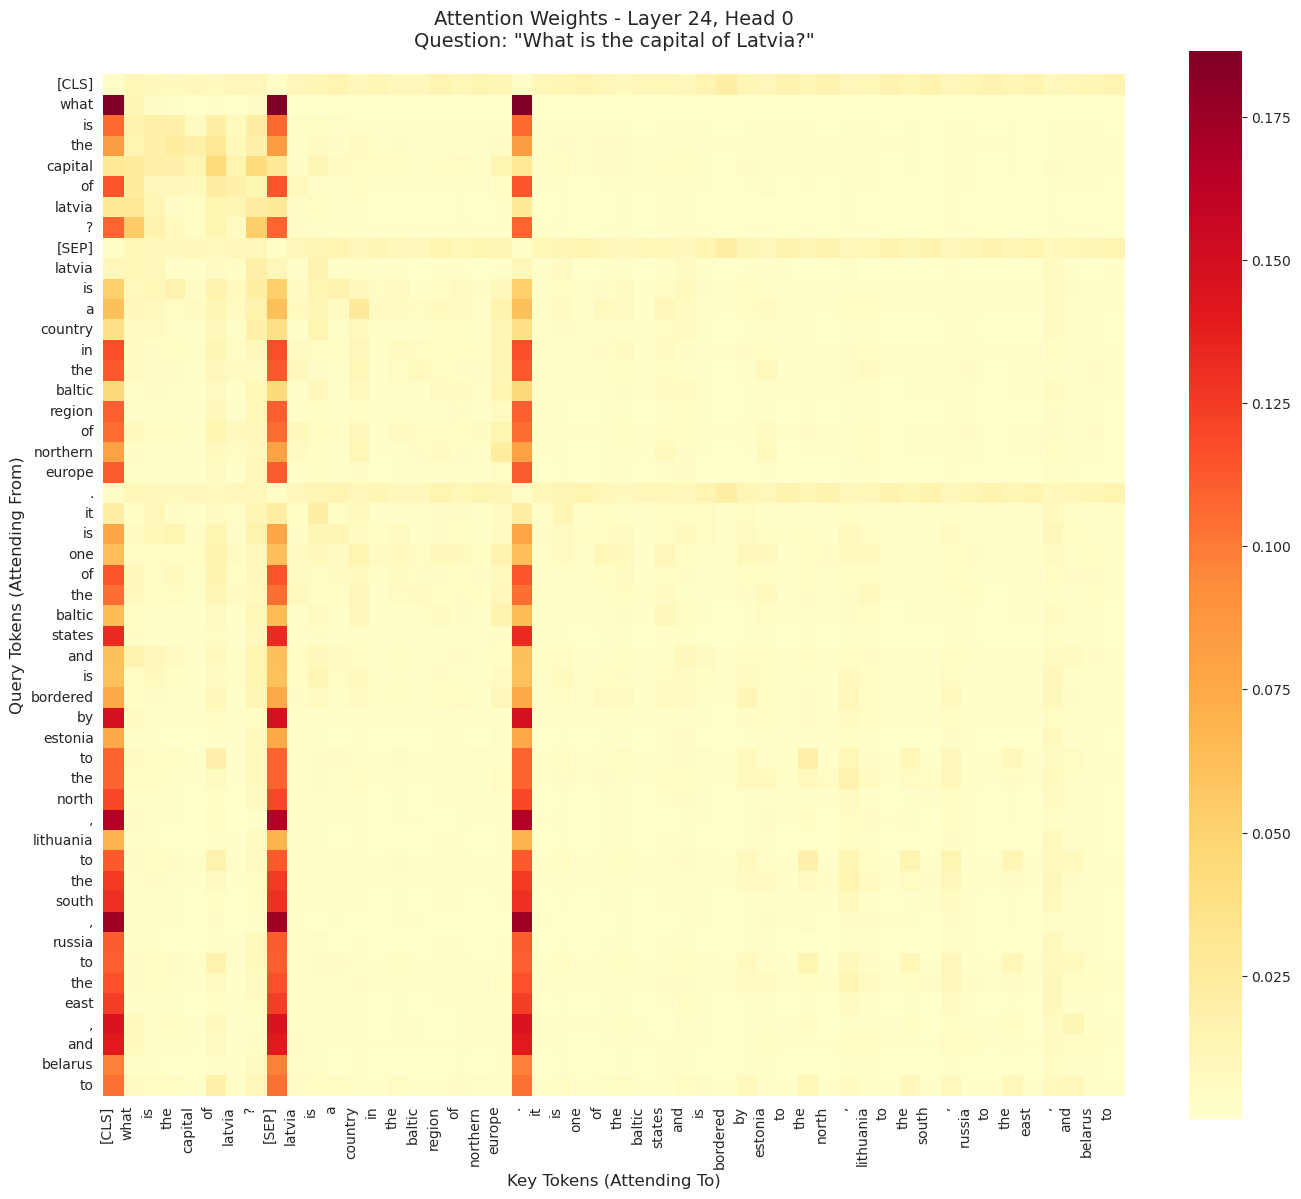

In [7]:
def plot_attention_heatmap(attention_matrix, tokens, layer_num, head_num, 
                          start_idx=None, end_idx=None, max_tokens=50):
    """
    Plot attention heatmap for a specific layer and head.
    
    Args:
        attention_matrix: Attention weights (seq_len x seq_len)
        tokens: List of tokens
        layer_num: Layer number
        head_num: Attention head number
        start_idx: Start index of answer (optional)
        end_idx: End index of answer (optional)
        max_tokens: Maximum number of tokens to display
    """
    # Limit to max_tokens for better visualization
    seq_len = min(len(tokens), max_tokens)
    attention_matrix = attention_matrix[:seq_len, :seq_len]
    tokens_display = tokens[:seq_len]
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(attention_matrix, 
                xticklabels=tokens_display, 
                yticklabels=tokens_display,
                cmap='YlOrRd',
                cbar=True,
                square=True)
    
    plt.title(f'Attention Weights - Layer {layer_num}, Head {head_num}\n' + 
              f'Question: "{question}"', fontsize=14, pad=20)
    plt.xlabel('Key Tokens (Attending To)', fontsize=12)
    plt.ylabel('Query Tokens (Attending From)', fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Highlight answer tokens if provided
    if start_idx is not None and end_idx is not None and start_idx < seq_len:
        end_display = min(end_idx, seq_len - 1)
        # Add rectangle around answer tokens
        plt.axvline(x=start_idx, color='blue', linewidth=2, linestyle='--', alpha=0.5)
        plt.axvline(x=end_display+1, color='blue', linewidth=2, linestyle='--', alpha=0.5)
        plt.axhline(y=start_idx, color='blue', linewidth=2, linestyle='--', alpha=0.5)
        plt.axhline(y=end_display+1, color='blue', linewidth=2, linestyle='--', alpha=0.5)
    
    plt.show()

# Visualize attention from the last layer, first head
last_layer_attention = attentions[-1][0]  # Shape: (num_heads, seq_len, seq_len)
attention_head_0 = last_layer_attention[0].numpy()  # First head

plot_attention_heatmap(attention_head_0, tokens, 
                       layer_num=num_layers, head_num=0,
                       start_idx=start_idx.item(), end_idx=end_idx.item())


## 5. Analyze Attention to Answer Tokens

Let's see which input tokens attend most to the answer tokens.


In [8]:
def analyze_answer_attention(attentions, tokens, start_idx, end_idx, top_k=10):
    """
    Analyze which tokens in the input attend most to the answer tokens.
    """
    # Average attention across all layers and heads
    all_attention = torch.stack([att[0] for att in attentions])  # (layers, heads, seq_len, seq_len)
    avg_attention = all_attention.mean(dim=[0, 1])  # Average over layers and heads
    
    # Get attention TO answer tokens (column sum for answer positions)
    answer_attention = avg_attention[:, start_idx:end_idx+1].sum(dim=1)
    
    # Get top-k tokens that attend to the answer
    top_values, top_indices = torch.topk(answer_attention, k=min(top_k, len(tokens)))
    
    print(f"\nTop {top_k} tokens attending to the answer '{answer}':")
    print(f"{'='*60}")
    for i, (idx, val) in enumerate(zip(top_indices, top_values)):
        token = tokens[idx]
        print(f"{i+1:2d}. Token: {token:15s} | Position: {idx:3d} | Attention: {val:.4f}")
    
    return avg_attention.numpy(), answer_attention.numpy()

avg_attention, answer_attention = analyze_answer_attention(
    attentions, tokens, start_idx.item(), end_idx.item()
)



Top 10 tokens attending to the answer 'riga':
 1. Token: is              | Position:  60 | Attention: 0.0540
 2. Token: ,               | Position:  62 | Attention: 0.0522
 3. Token: riga            | Position:  61 | Attention: 0.0451
 4. Token: riga            | Position:  76 | Attention: 0.0435
 5. Token: which           | Position:  63 | Attention: 0.0411
 6. Token: what            | Position:   1 | Attention: 0.0328
 7. Token: is              | Position:  64 | Attention: 0.0311
 8. Token: capital         | Position:  54 | Attention: 0.0307
 9. Token: city            | Position:  57 | Attention: 0.0297
10. Token: the             | Position:  53 | Attention: 0.0264


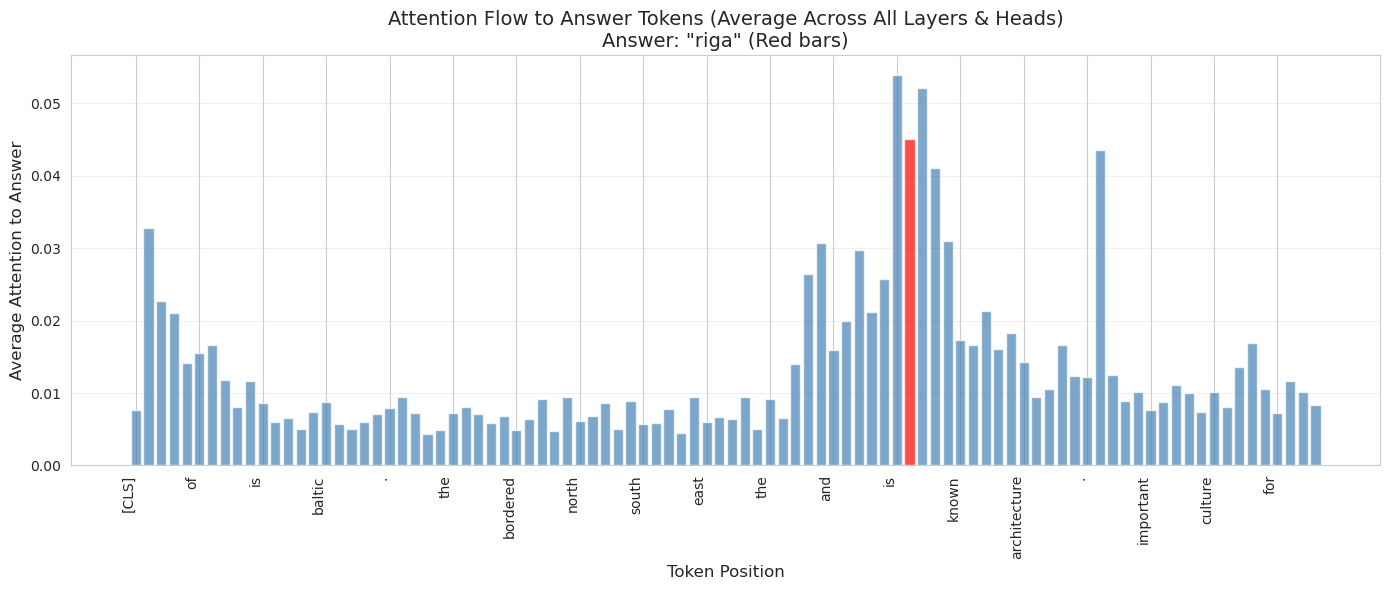

In [9]:
# Visualize which tokens attend most to the answer
plt.figure(figsize=(14, 6))

# Plot attention scores for all tokens
x_pos = np.arange(len(answer_attention))
colors = ['red' if start_idx <= i <= end_idx else 'steelblue' 
          for i in range(len(answer_attention))]

plt.bar(x_pos, answer_attention, color=colors, alpha=0.7)
plt.xlabel('Token Position', fontsize=12)
plt.ylabel('Average Attention to Answer', fontsize=12)
plt.title(f'Attention Flow to Answer Tokens (Average Across All Layers & Heads)\n' + 
          f'Answer: "{answer}" (Red bars)', fontsize=14)
plt.xticks(x_pos[::5], [tokens[i] for i in x_pos[::5]], rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Visualize Multiple Attention Heads

Different attention heads capture different patterns. Let's look at a few.


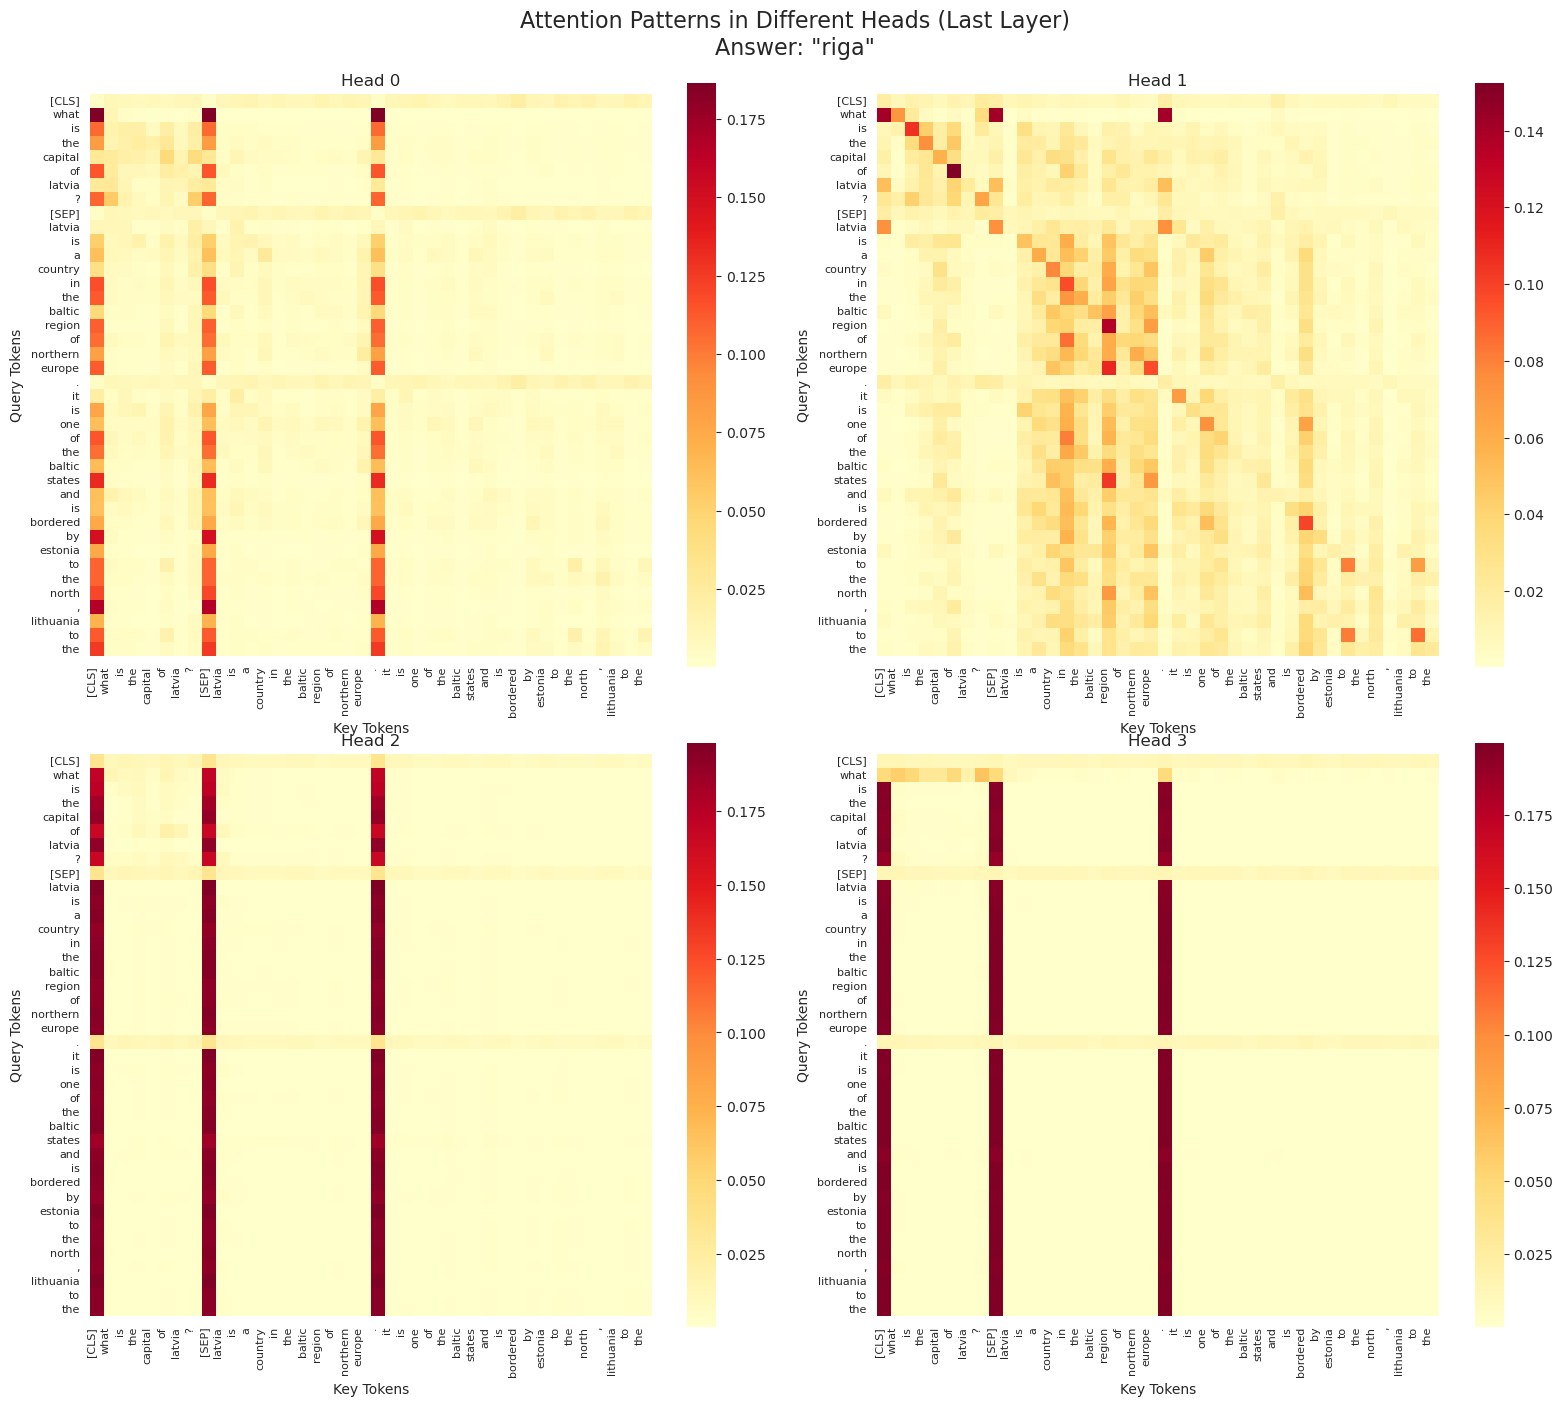

In [10]:
# Visualize multiple heads from the last layer
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle(f'Attention Patterns in Different Heads (Last Layer)\nAnswer: "{answer}"', 
             fontsize=16, y=0.995)

max_display = 40  # Limit tokens for readability

for i, ax in enumerate(axes.flat):
    if i < num_heads:
        attention_matrix = last_layer_attention[i][:max_display, :max_display].numpy()
        tokens_display = tokens[:max_display]
        
        sns.heatmap(attention_matrix, 
                   xticklabels=tokens_display,
                   yticklabels=tokens_display,
                   cmap='YlOrRd',
                   ax=ax,
                   cbar=True,
                   square=True)
        
        ax.set_title(f'Head {i}', fontsize=12)
        ax.set_xlabel('Key Tokens', fontsize=10)
        ax.set_ylabel('Query Tokens', fontsize=10)
        ax.tick_params(axis='both', labelsize=8)
        plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


## 7. Try Your Own Question!

Modify the cell below to explore different questions and contexts.


Question: When was Riga established as an important center?
Answer: centuries


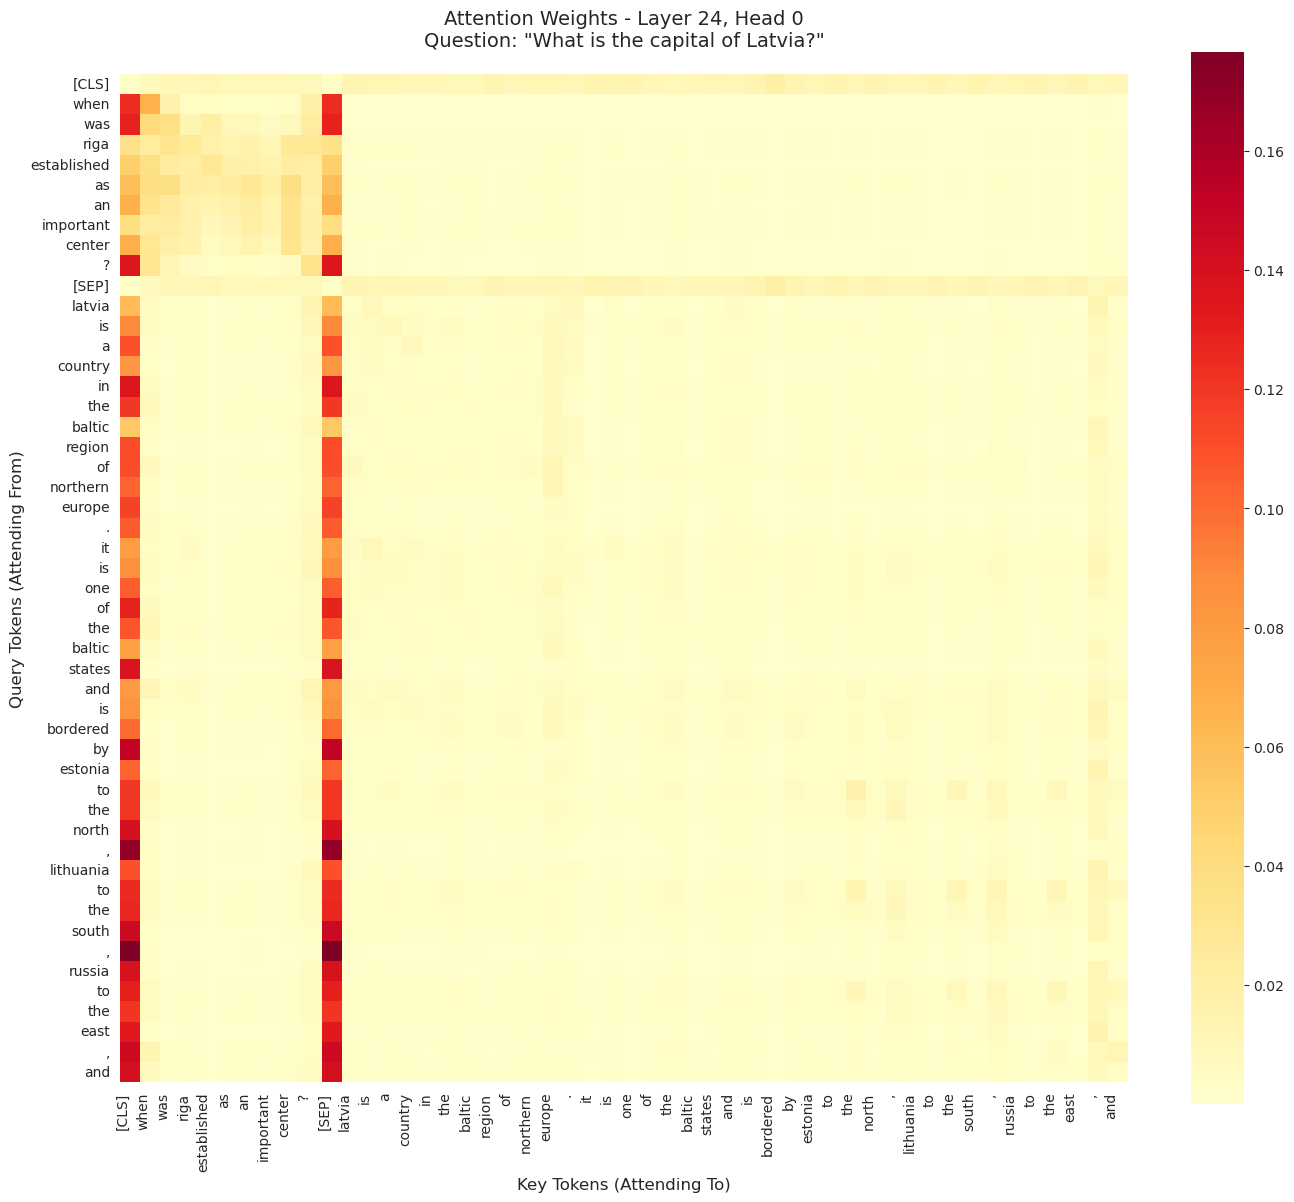

('centuries',
 ['[CLS]',
  'when',
  'was',
  'riga',
  'established',
  'as',
  'an',
  'important',
  'center',
  '?',
  '[SEP]',
  'latvia',
  'is',
  'a',
  'country',
  'in',
  'the',
  'baltic',
  'region',
  'of',
  'northern',
  'europe',
  '.',
  'it',
  'is',
  'one',
  'of',
  'the',
  'baltic',
  'states',
  'and',
  'is',
  'bordered',
  'by',
  'estonia',
  'to',
  'the',
  'north',
  ',',
  'lithuania',
  'to',
  'the',
  'south',
  ',',
  'russia',
  'to',
  'the',
  'east',
  ',',
  'and',
  'belarus',
  'to',
  'the',
  'southeast',
  '.',
  'the',
  'capital',
  'and',
  'largest',
  'city',
  'of',
  'latvia',
  'is',
  'riga',
  ',',
  'which',
  'is',
  'known',
  'for',
  'its',
  'art',
  'nouveau',
  'architecture',
  'and',
  'vibrant',
  'cultural',
  'scene',
  '.',
  'riga',
  'has',
  'been',
  'an',
  'important',
  'center',
  'of',
  'trade',
  'and',
  'culture',
  'in',
  'the',
  'baltic',
  'region',
  'for',
  'centuries',
  '.',
  '[SEP]'],
 Quest

In [11]:
def answer_question(question, context, visualize=True):
    """
    Answer a question given context and optionally visualize attention.
    """
    # Tokenize
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=512)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract answer
    start_idx = torch.argmax(outputs.start_logits)
    end_idx = torch.argmax(outputs.end_logits)
    answer_tokens = tokens[start_idx:end_idx+1]
    answer = tokenizer.convert_tokens_to_string(answer_tokens)
    
    print(f"Question: {question}")
    print(f"Answer: {answer}")
    
    if visualize and len(tokens) > 0:
        # Visualize last layer, first head
        last_layer_attention = outputs.attentions[-1][0]
        attention_head_0 = last_layer_attention[0].numpy()
        
        plot_attention_heatmap(attention_head_0, tokens, 
                             layer_num=len(outputs.attentions), head_num=0,
                             start_idx=start_idx.item(), end_idx=end_idx.item())
    
    return answer, tokens, outputs

# Try with a different question!
new_question = "When was Riga established as an important center?"
new_context = context  # Use the same context or provide a new one

answer_question(new_question, new_context)


## Summary

This notebook demonstrated:

1. **RAG Concept**: We provided context (retrieved information) along with a question to augment the model's generation
2. **BERT QA**: Used a pretrained BERT model fine-tuned for question answering
3. **Attention Visualization**: Visualized attention matrices to understand:
   - Which tokens the model focuses on when generating answers
   - How different attention heads capture different patterns
   - The flow of information from context to answer

The attention weights reveal how BERT identifies relevant information in the context to answer questions!
